<a href="https://colab.research.google.com/github/Maxxx-VS/The-Founder/blob/master/Detected_sarcasm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Навигация по уроку**

1. [Первое знакомство с AutoML](https://colab.research.google.com/drive/1bCWyzlp1-tcvt7TE60m4hFnRd5AWscWY)
2. [Гиперпараметры и оптимизация моделей](https://colab.research.google.com/drive/1CN69NftfVXUliyv11FGbM7qOYbO0XON5)
3. [AutoML в Keras](https://colab.research.google.com/drive/1V7mfY8da0S-FbWxhQbchJM38JSJBmtoZ)
4. Домашняя работа

В домашней работе необходимо с помощью AutoKeras или KerasTuner найти оптимальную модель для решения одной из следующей задач:

1. На 3 балла. Обучите модель с точностью не менее 90% предсказывать сарказм в новостных заголовках. Составьте 5 произвольных заголовков, которых нет в датасете и проверьте на них обученную модель, сделайте выводы. Ссылка на [датасет](https://storage.yandexcloud.net/academy.ai/Sarcasm_Headlines_Dataset_v2.json.zip).
2. На 4 балла. Используйте [русский корпус новостей от Lenta.ru](https://www.kaggle.com/datasets/yutkin/corpus-of-russian-news-articles-from-lenta/data) подберите и обучите модель классифицировать новости по заголовкам на классы (поле topic в датасете). Используйте 9 самых часто встречаемых топиков и 10-й для остальных, не вошедших в 9 классов. Оцените модель с помощью отчета о классификации, сделайте выводы.  
3. На 5 баллов. Найдите публичный датасет по обращениям граждан в администрацию, техническую поддержку или за консультацией. Обучите модель классифицировать обращения по тематикам. Сформируйте отчет о классификации и матрицу ошибок.

In [1]:
!wget https://storage.yandexcloud.net/academy.ai/Sarcasm_Headlines_Dataset_v2.json.zip
!unzip -qo "Sarcasm_Headlines_Dataset_v2.json.zip" -d ./dataset
!pip install autokeras==1.1.0 tensorflow==2.15.1 keras-nlp==0.5.1

--2024-10-30 07:54:52--  https://storage.yandexcloud.net/academy.ai/Sarcasm_Headlines_Dataset_v2.json.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1789636 (1.7M) [application/x-zip-compressed]
Saving to: ‘Sarcasm_Headlines_Dataset_v2.json.zip’

Sarcasm_Headlines_D 100%[===================>]   1.71M  1.61MB/s    in 1.1s    

2024-10-30 07:54:54 (1.61 MB/s) - ‘Sarcasm_Headlines_Dataset_v2.json.zip’ saved [1789636/1789636]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.1/527.1 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2

In [2]:
import tensorflow as tf
import keras_nlp as nlp
import numpy as np
import pandas as pd
import re
import tensorflow as tf
import autokeras as ak
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Утилита для расщепления выборки
from sklearn.model_selection import train_test_split

# Необходимые метрики для построения Матрицы ошибок и отчета о классификации
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
address = "./dataset/Sarcasm_Headlines_Dataset_v2.json"
json_df = pd.read_json(address, lines = True ) # библиотека pandas умеет работать с json данными
df_sarcasm = pd.DataFrame(json_df) # создаем датафрейм

df_sarcasm.head() # выводим первые 5 записей датафрейма

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [4]:
# Ссылки на сами статьи нам не нужны
df_sarcasm = df_sarcasm.drop("article_link", axis = 1)
print('Найдено дубликатов: ', df_sarcasm.duplicated().sum())

# Удаляем дубликаты
df_sarcasm.drop_duplicates(subset=['headline'], inplace = True)
print('Осталось дубликатов после очистки: ', df_sarcasm.duplicated().sum())

Найдено дубликатов:  116
Осталось дубликатов после очистки:  0


In [5]:
X_train, X_tmp, y_train, y_tmp = train_test_split(np.array(df_sarcasm.headline), np.array(df_sarcasm.is_sarcastic), test_size=0.2)

X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5)

In [6]:
print('Форма входных данных: ', X_train.shape)
print('Форма выходных меток: ', y_train.shape)
print('Пример заголовка: ', X_train[0])

Форма входных данных:  (22802,)
Форма выходных меток:  (22802,)
Пример заголовка:  alan colmes loses argument with nephew


In [7]:
del df_sarcasm, X_tmp, y_tmp

In [24]:
# Создание ансамбля моделей (3 наиболее подходящие к данным моделей)
clf = ak.TextClassifier(overwrite=True, max_trials=2, objective='val_accuracy')

result_training = clf.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Trial 2 Complete [00h 02m 08s]
val_accuracy: 0.8603509068489075

Best val_accuracy So Far: 0.8603509068489075
Total elapsed time: 00h 05m 17s
Epoch 1/20
713/713 [==============================] - 184s 254ms/step - loss: 0.7401 - accuracy: 0.5343 - val_loss: 0.9718 - val_accuracy: 0.5786
Epoch 2/20
713/713 [==============================] - 180s 253ms/step - loss: 0.5380 - accuracy: 0.7234 - val_loss: 0.5928 - val_accuracy: 0.7586
Epoch 3/20
713/713 [==============================] - 180s 252ms/step - loss: 0.3622 - accuracy: 0.8380 - val_loss: 0.4764 - val_accuracy: 0.8239
Epoch 4/20
713/713 [==============================] - 180s 253ms/step - loss: 0.2486 - accuracy: 0.8989 - val_loss: 0.6832 - val_accuracy: 0.7867
Epoch 5/20
713/713 [==============================] - 180s 252ms/step - loss: 0.1809 - accuracy: 0.9315 - val_loss: 0.7759 - val_accuracy: 0.8021
Epoch 6/20
713/713 [==============================] - 180s 253ms/step - loss: 0.1340 - accuracy: 0.9490 - val_loss: 0.7527 - val

In [25]:
# Последовательно экспортируем лучшую модель и по ней выводим отчет
clf.export_model().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 expand_last_dim (ExpandLas  (None, 1)                    0         ['input_1[0][0]']             
 tDim)                                                                                            
                                                                                                  
 text_vectorization (TextVe  (None, 512)                  0         ['expand_last_dim[0][0]']     
 ctorization)                                                                                     
                                                                                              

In [26]:
# Предсказание на лучшей модели
predicted_y = clf.predict(X_test)

# Оценка лучшей модели на тестовых данных
print(clf.evaluate(X_test, y_test))

90/90 [==============================] - 10s 111ms/step - loss: 1.3244 - accuracy: 0.8341
[1.3244264125823975, 0.8340932726860046]


In [31]:
def plot_graphs(history, key):
    # Используем библиотеку seaborn для задания стиля и цветовой схемы графика
    sns.set_style('darkgrid')
    palette = sns.color_palette('Set1')

    # Задаем размер полотна для рисования графика
    plt.figure(figsize=(6,3))

    # Отображаем график выбранного параметра
    plt.plot(history.history[key],   # данные для построения графика
             marker='o',             # использовать маркер для точек на графике
             color=palette[2],       # использовать цвет третий в палитре (нумерация с 0)
             linewidth=2.5,          # ширина линии
             label=key)              # подпись легенды

    # График для проверочной выборки
    if 'val_'+key in history.history:
        plt.plot(history.history['val_'+key], # данные для построения графика
                 marker='o',                  # использовать маркер для точек на графике
                 color=palette[4],            # использовать цвет пятый в палитре
                 linewidth=2.5,               # ширина линии
                 label='val_'+key)            # подпись легенды

    # подпись оси Х, размер шрифта - 12
    plt.xlabel("Эпоха", fontsize=12)
    # подпись оси Y, размер шрифта - 12
    plt.ylabel(key, fontsize=12)

    # подпись заголовка графика, размер шрифта - 14
    plt.title('Обучающая и проверочная выборки ('+key.title()+')', fontsize=14)

    # отображение легенды, размер шрифта - 12
    plt.legend(fontsize=12)

    # задаем сетку на графике
    plt.grid(True)

    # отрисовываем полотно со всеми графиками
    plt.show()

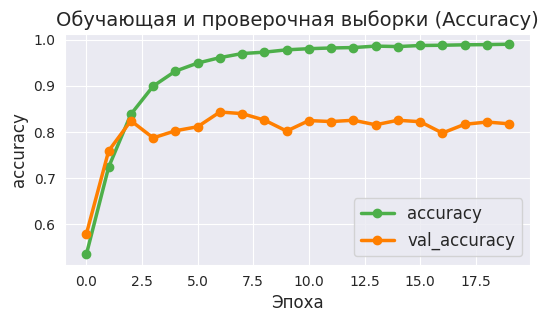

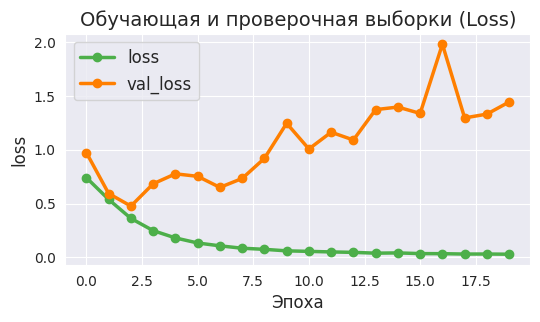

In [32]:
# строим график точности
plot_graphs(result_training, "accuracy")

# строим график потерь
plot_graphs(result_training, "loss")

In [29]:
print(classification_report(y_test, predicted_y))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1471
           1       0.83      0.83      0.83      1380

    accuracy                           0.83      2851
   macro avg       0.83      0.83      0.83      2851
weighted avg       0.83      0.83      0.83      2851



In [30]:
# Определим функцию предсказания сарказма
def predict_sarcasm(text, model):
    # Предсказание
    result = model.predict(np.array([text]))
    if result[0] == 0:
        print("Предложение: '{}' не содержит сарказма.".format(text))
    elif result[0] == 1:
        print("Предложение : '{}' содержит сарказм.".format(text))

# Произвольные фразы, в которых мы предполагаем наличие сарказма или его отсутствие
sarcasm = "Oh, wonderful! My computer crashes right before I save my work."
without_sarcasm = "I love spending time with my family during the holidays."

# Выполняем функции
predict_sarcasm(sarcasm, clf)
predict_sarcasm(without_sarcasm, clf)

1/1 [==============================] - 0s 25ms/step
Предложение: 'Oh, wonderful! My computer crashes right before I save my work.' не содержит сарказма.
1/1 [==============================] - 0s 26ms/step
Предложение: 'I love spending time with my family during the holidays.' не содержит сарказма.
